In [62]:
import numpy as np
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [63]:
from MolGAN.sparse_molecular_dataset import SparseMolecularDataset

In [64]:
data = SparseMolecularDataset()

In [4]:
## BEFORE USING THIS SCRIPT YOU NEED TO DOWNLOAD DATA FILE, CHECK MolGAN/Data/download.sh file

In [4]:
# data.generate('/scratch/fkrithik/MolGAN-TF2--main/MolGAN/data/gdb9/gdb9.sdf')
# data.save('./MolGAN/data/gdb9.sparsedataset')
# data.load('./MolGAN/data/gdb9.sparsedataset')


In [ ]:
## USING SMILES FILE

In [5]:
#data.generate('../Data/zinc_1M.smi',filters=lambda x: x is not None, size=200000, test=0, validation=0)
#data.save('./MolGAN/data/zinc_200K.sparsedataset')
#data.load('./MolGAN/data/zinc.sparsedataset')

In [65]:
#use data.generate(path) to generate dataset file which then can be loaded
data.load('./MolGAN/data/gdb9.sparsedataset')

In [66]:
from MolGAN.layers import *
from MolGAN.molecular_metrics import MolecularMetrics
from functools import partial
class GraphGANModel(object):
    def __init__(self, data, embedding_dim = 8, decoder_units = (128,256,512), discriminator_units=[(128,64),128,(128,64)], dropout_rate= 0., batch_discriminator=False):
        
        #number of features is data
        self.vertices = data.vertexes
        #number of bond types in data
        self.edges = data.bond_num_types
        #number of atom types in data
        self.nodes = data.atom_num_types
        #controls layers in the decoder model
        self.decoder_units = decoder_units
        #controls layers in the dicriminator layer
        self.discriminator_units = discriminator_units
        #used by dropout layer
        self.dropout_rate = dropout_rate
        #used in discriminator
        self.batch_discriminator = batch_discriminator
        #size of input for generator, controls random sample size
        self.embedding_dim = embedding_dim
        #used for during preparation of the fake sample
        self.temperature = 1.
        self.soft_gumbel_softmax = tf.constant(False)
        self.hard_gumbel_softmax = tf.constant(False)

        
        #OPTIMIZERS
        self.learning_rate = 1e-3
        self.optimizer_discriminator = keras.optimizers.Adam(self.learning_rate)
        self.optimizer_RL =keras.optimizers.Adam(self.learning_rate)
        self.optimizer_generator = keras.optimizers.Adam(self.learning_rate)
        #MODELS
        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()
        self.RL = self.create_RL()
        #COMPILATION TO ENABLE EASY SAVING
        self.discriminator.compile(optimizer=self.optimizer_discriminator)
        self.generator.compile(optimizer=self.optimizer_generator)
        self.RL.compile(optimizer=self.optimizer_RL)
        
        #control batch size
        self.batch_size = 100
        #determines influence of reiforcement model 1 = no impact, 0 = only reinforcement 
        self.la = 0.8
        #should features rather than logits be used in generator training, can improve diversity if turned on
        self.feature_matching=True
        #WGAN penalty impact, see Discrimnator training
        self.penalty_weight=10
        #Which metric use with reinforcement learning, use 'all' for all metrics, see reward function for more metrics
        self.metric = 'validity,logp'
        #how many times discriminator is trained per single generator training
        self.n_critic = 5
        #stores training, evaluation and validation data, currently on training data is used
        self.data = data
        #how many steps per epoch training requires
        self.steps = len(self.data)//self.batch_size
        
        #used by reinforcement learning
        self.rewardR = []
        #used by reinforcement learning
        self.rewardF = []
    
    ############################################ MODELS ############################################################
    '''Build generator model'''
    def create_generator(self):
        input_layer = layers.Input(shape=(self.embedding_dim))
        
        x = layers.Dense(128, activation='tanh')(input_layer)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(256, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(512, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        
        #EDGES LOGITS
        edges_logits = layers.Dense(units=self.edges*self.vertices*self.vertices, activation=None)(x)
        edges_logits = layers.Reshape((self.edges, self.vertices, self.vertices))(edges_logits)
        matrix_transpose = layers.Permute((1,3,2))(edges_logits)
        edges_logits = (edges_logits + matrix_transpose)/2
        edges_logits = layers.Permute((2,3,1))(edges_logits)
        edges_logits = layers.Dropout(self.dropout_rate)(edges_logits)
        
        #NODES LOGITS
        nodes_logits = layers.Dense(units=(self.vertices * self.nodes), activation=None)(x)
        nodes_logits = layers.Reshape((self.vertices, self.nodes))(nodes_logits)
        nodes_logits = layers.Dropout(self.dropout_rate)(nodes_logits)
        return keras.Model(inputs = input_layer, outputs=[edges_logits, nodes_logits])
    
    '''Build discriminator aka critic model'''
    def create_discriminator(self):
        adjacency_tensor = layers.Input(shape=(self.vertices, self.vertices, self.edges), name='disc_adjacency_input')
        node_tensor = layers.Input(shape=(self.vertices, self.nodes), name='disc_node_input')

        outputs0 = EncoderV2(
            units=self.discriminator_units[:-1],
            dropout_rate=self.dropout_rate,
            edges=self.edges,
            name="disc_encoder"
        )([adjacency_tensor, node_tensor])

        outputs1 = MultiDenseLayer(
            units=self.discriminator_units[-1],
            activation='tanh',
            dropout_rate=self.dropout_rate,
            name="disc_multidense"
        )(outputs0)

        if self.batch_discriminator:
            u = self.discriminator_units[-2] // 8
            outputs_batch = layers.Dense(units=u, activation='tanh', name="disc_batch_dense_1")(outputs0)
            outputs_batch = tf.reduce_mean(outputs_batch, 0, keepdims=True)
            outputs_batch = layers.Dense(units=u, activation='tanh', name="disc_batch_dense_2")(outputs_batch)
            outputs_batch = tf.tile(outputs_batch, (tf.shape(outputs0)[0], 1))
            outputs1 = layers.Concatenate(axis=-1, name="disc_concat")([outputs1, outputs_batch])

        outputs = layers.Dense(units=1, name="disc_final_dense")(outputs1)

        return keras.Model(inputs=[adjacency_tensor, node_tensor], outputs=[outputs, outputs1], name="discriminator_model")

    '''Build reinforcement learning model'''
    def create_RL(self):
        adjacency_tensor = layers.Input(
            shape=(self.vertices, self.vertices, self.edges),
            name='rl_adjacency_input'
        )
        node_tensor = layers.Input(
            shape=(self.vertices, self.nodes),
            name='rl_node_input'
        )

        outputs = EncoderV2(
            units=self.discriminator_units[:-1],
            dropout_rate=self.dropout_rate,
            edges=self.edges,
            name="rl_encoder"
        )([adjacency_tensor, node_tensor])

        outputs = MultiDenseLayer(
            units=self.discriminator_units[-1],
            activation='tanh',
            dropout_rate=self.dropout_rate,
            name="rl_multidense"
        )(outputs)

        outputs = layers.Dense(1, activation='sigmoid', name="rl_final_dense")(outputs)

        return keras.Model(inputs=[adjacency_tensor, node_tensor], outputs=outputs, name="RL_model")

    ############################################ MODELS END###########################################################
    
    ############################################ TRAINING ############################################################
    '''Function used for training generator'''
    @tf.function
    def train_generator(self, inputs):
        embedding = self.gaussian_noise(self.batch_size)
        adj_tensor, node_tensor  = inputs
        
        with tf.GradientTape() as tape:
            tape.watch(adj_tensor)
            tape.watch(node_tensor)
                        
            edges_logits, nodes_logits = self.generator(embedding, training=True)
            edges_hat, nodes_hat = self.fake_input([edges_logits, nodes_logits],self.soft_gumbel_softmax, self.hard_gumbel_softmax, self.temperature)           
            
            logits_fake, features_fake = self.discriminator([edges_hat, nodes_hat], training=True)
            
            if self.feature_matching:
                logits_real, features_real = self.discriminator([adj_tensor, node_tensor], training=True)
                loss_G = tf.reduce_sum((tf.reduce_mean(features_real, 0) - tf.reduce_mean(features_fake, 0)) ** 2)
            else:
                loss_G = -tf.reduce_mean(logits_fake)
                
            #should training utilize reinforcement learning, change to tf.cond? i.e. self.la could be changed as part of the training in order to allow RL pretraining
            if self.la<1:
                value_logits_fake = self.RL([edges_hat,nodes_hat], training=True)  
                loss_RL = -value_logits_fake
                loss_RL = tf.reduce_mean(loss_RL)
                alpha = tf.abs(tf.stop_gradient(loss_G / loss_RL))
                loss=tf.cond(tf.greater(self.la, 0), lambda: self.la * loss_G, lambda: 0.) + tf.cond(tf.less(self.la, 1), lambda: (1 - self.la) * alpha * loss_RL, lambda: 0.)
            else:
                loss = loss_G
            
        gradients = tape.gradient(loss,self.generator.trainable_variables)
        self.optimizer_generator.apply_gradients(zip(gradients, self.generator.trainable_variables))
        return loss
    
    '''Function used for training discriminator'''
    @tf.function
    def train_discriminator(self, inputs):
            embedding = self.gaussian_noise(self.batch_size)
            adjacency_tensor, node_tensor = inputs
            
            with tf.GradientTape() as tape:

                tape.watch(adjacency_tensor)
                tape.watch(node_tensor)
                
                edges_logits, nodes_logits = self.generator(embedding, training=True)
                edges_hat, nodes_hat = self.fake_input([edges_logits, nodes_logits],self.soft_gumbel_softmax, self.hard_gumbel_softmax, self.temperature)
                edges_softmax, nodes_softmax = self.fake_input([edges_logits, nodes_logits],False, False, self.temperature)
                               
                logits_real, features_real = self.discriminator([adjacency_tensor, node_tensor], training=True)
                logits_fake, features_fake = self.discriminator([edges_hat, nodes_hat], training=True)
                
                eps = tf.random.uniform(tf.shape(logits_real)[:1], dtype=logits_real.dtype)
                eps_a = tf.expand_dims(tf.expand_dims(tf.expand_dims(eps, -1), -1), -1)
                eps_n = tf.expand_dims(tf.expand_dims(eps, -1), -1)
                x_int0 = adjacency_tensor * eps_a +  edges_softmax * (1 - eps_a)
                x_int1 = node_tensor * eps_n + nodes_softmax * ( 1 - eps_n)
        
                grad_penalty = self.gradient_penalty(partial(self.discriminator, training=True),x_int0, x_int1)
                                      
                #calculate loss
                loss_D = -logits_real + logits_fake
                loss_D = tf.reduce_mean(loss_D)
                grad_penalty = tf.reduce_mean(grad_penalty)
                cost = loss_D + self.penalty_weight * grad_penalty
            #calculate overall gradients and apply them
            gradients = tape.gradient(cost, self.discriminator.trainable_variables)
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
            return cost
        
    '''Function used for training reinforcement model'''
    @tf.function   
    def train_RL(self, inputs):
        embedding = self.gaussian_noise(self.batch_size)
        adjacency_tensor, node_tensor = inputs
               
        with tf.GradientTape() as tape:
                tape.watch(adjacency_tensor)
                tape.watch(node_tensor)
                
                edges_logits, nodes_logits = self.generator(embedding, training=True)
                edges_hat, nodes_hat = self.fake_input([edges_logits, nodes_logits],self.soft_gumbel_softmax, self.hard_gumbel_softmax, self.temperature)
                
                logits_real_RL = self.RL([adjacency_tensor, node_tensor], training=True)
                logits_fake_RL = self.RL([edges_hat, nodes_hat], training=True)
                
                loss_V = (logits_real_RL - self.rewardR) ** 2 + (logits_fake_RL - self.rewardF) ** 2
                loss = tf.reduce_mean(loss_V)
        gradients = tape.gradient(loss, self.RL.trainable_variables)
        self.optimizer_RL.apply_gradients(zip(gradients, self.RL.trainable_variables))
        return loss
    
    '''Used in discriminator/RL loss calculations: Improved Training of Wasserstein GANs, https://arxiv.org/abs/1704.00028 '''  
    @tf.function
    def gradient_penalty(self,func,x0,x1):
        with tf.GradientTape() as tape:
            tape.watch(x0)
            tape.watch(x1)
            pred = func([x0, x1])
        grad0, grad1 = tape.gradient(pred,(x0,x1))
        grad_penalty = tf.reduce_mean(((1 - tf.norm(grad0, axis=-1)) ** 2), (-2, -1)) + tf.reduce_mean(((1 - tf.norm(grad1, axis=-1)) ** 2), -1, keepdims=True)

        return grad_penalty
        
    '''Main training method'''
    def train(self, epochs):
       
        for epoch in range(epochs):
            g_losses = []
            d_losses = []
            rl_losses = []
            
            print('epoch {}/{} started'.format(epoch+1, epochs))
            
            for step in range(self.steps):
                mols,_,_,a,x,_,_,_,_ = self.data.next_train_batch(self.batch_size)
                #generate real data reward
                self.rewardR = self.reward(mols)

                #get fake data reward
                n, e = self.generate(self.batch_size)
                mols = [self.data.matrices2mol(n_,e_, strict=True) for n_, e_ in zip(n,e)]
                self.rewardF = self.reward(mols)

                #convert to one hot
                adjacency_tensor = tf.one_hot(a, depth=self.edges, dtype=tf.float32)
                node_tensor = tf.one_hot(x, depth = self.nodes, dtype=tf.float32)
                
                #TRAIN DISCRIMINATOR
                for i in range(self.n_critic):
                    d_loss = self.train_discriminator([adjacency_tensor,node_tensor])
                    d_losses.append(d_loss)
                
                #TRAIN GENERATOR
                g_loss = self.train_generator([adjacency_tensor,node_tensor])
                g_losses.append(g_loss)
                
                #TRAIN REINFORCE
                if self.la < 1:
                    rl_loss = self.train_RL([adjacency_tensor,node_tensor])
                    rl_losses.append(rl_loss)
                    
            #report losses over epoch
            generator_loss = np.mean(g_losses)
            discriminator_loss = np.mean(d_losses)
            if self.la<1:
                reinforce_loss = np.mean(rl_losses)
            else:
                reinforce_loss = 'not calculated'
            
            print('Generator loss:{} ### Discriminator loss:{} ### Reinforce loss:{}'.format(generator_loss, discriminator_loss, reinforce_loss))
            
    '''Generate N number of artificial samples '''              
    def generate(self, samples):
        embedding = self.gaussian_noise(samples)
        edges_logits, nodes_logits = self.generator(embedding, training=False)
        _,_,_,_,argmax = self.postprocess_logits([nodes_logits, edges_logits])
        n,e = argmax
        n,e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
        return n, e
        

    ############################################ TRAINING END ########################################################
               
    ##CUSTOM METHODS
    '''Processes logits into useful form'''
    def postprocess_logits(self, inputs, temperature=1.):

        def listify(x):
            return x if type(x) == list or type(x) == tuple else [x]

        def delistify(x):
            return x if len(x) > 1 else x[0]

        softmax = [tf.nn.softmax(e_logits / temperature) for e_logits in listify(inputs)]
        argmax = [tf.one_hot(tf.argmax(e_logits, axis=-1), depth=e_logits.shape[-1], dtype=e_logits.dtype) for e_logits in listify(inputs)]
        gumbel_logits = [e_logits - tf.math.log(- tf.math.log(tf.random.uniform(tf.shape(e_logits), dtype=e_logits.dtype))) for e_logits in listify(inputs)]
        gumbel_softmax = [tf.nn.softmax(e_gumbel_logits / temperature) for e_gumbel_logits in gumbel_logits]
        gumbel_argmax = [tf.one_hot(tf.argmax(e_gumbel_logits, axis=-1), depth=e_gumbel_logits.shape[-1], dtype=e_gumbel_logits.dtype) for e_gumbel_logits in gumbel_logits]

        return [delistify(e) for e in (softmax, argmax, gumbel_logits, gumbel_softmax, gumbel_argmax)]
    
    '''Generate gaussian noise of given batch size'''
    @tf.function
    def gaussian_noise (self, batch_size):
        return tf.random.normal(shape=(batch_size,self.embedding_dim))
    
    '''Generate fake inputs'''
    def fake_input(self,inputs,soft_gumbel_softmax=False, hard_gumbel_softmax=False, temperature=1.):
        soft_gumbel_softmax = tf.constant(soft_gumbel_softmax, dtype='bool', shape=())
        hard_gumbel_softmax = tf.constant(hard_gumbel_softmax, dtype='bool', shape=())

        (edges_softmax, nodes_softmax),\
        (edges_argmax, nodes_argmax),\
        (edges_gumbel_logits, nodes_gumbel_logits), \
        (edges_gumbel_softmax, nodes_gumbel_softmax),\
        (edges_gumbel_argmax, nodes_gumbel_argmax) = self.postprocess_logits(inputs, temperature=temperature)

        edges_hat = tf.case([(soft_gumbel_softmax, lambda: edges_gumbel_softmax),
                             (hard_gumbel_softmax, lambda: tf.stop_gradient(edges_gumbel_argmax - edges_gumbel_softmax) + edges_gumbel_softmax)],
                             default=lambda: edges_softmax, exclusive=True)

        nodes_hat = tf.case([(soft_gumbel_softmax, lambda: nodes_gumbel_softmax),
                             (hard_gumbel_softmax, lambda: tf.stop_gradient(nodes_gumbel_argmax - nodes_gumbel_softmax) + nodes_gumbel_softmax)],
                            default=lambda: nodes_softmax, exclusive=True)

        return edges_hat, nodes_hat
    
    '''Method used for calculation of reward used in reinforcement model'''
    def reward(self,mols):
            # Filter out None or invalid mols
        mols = [mol for mol in mols if mol is not None and Chem.SanitizeMol(mol, catchErrors=True) == Chem.SanitizeFlags.SANITIZE_NONE]

        if not mols:
            return np.zeros((self.batch_size, 1))
        rr = 1.
        for m in ('logp,sas,qed,unique' if self.metric == 'all' else self.metric).split(','):

            if m == 'np':
                rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
            elif m == 'logp':
                rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
            elif m == 'sas':
                rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
            elif m == 'qed':
                rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
            elif m == 'novelty':
                rr *= MolecularMetrics.novel_scores(mols, self.data)
            elif m == 'dc':
                rr *= MolecularMetrics.drugcandidate_scores(mols, self.data)
            elif m == 'unique':
                rr *= MolecularMetrics.unique_scores(mols)
            elif m == 'diversity':
                rr *= MolecularMetrics.diversity_scores(mols, self.data)
            elif m == 'validity':
                rr *= MolecularMetrics.valid_scores(mols)
            else:
                raise RuntimeError('{} is not defined as a metric'.format(m))

        return rr.reshape(-1, 1)




In [67]:
g = GraphGANModel(data)

In [68]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


In [69]:
g.train(10)

epoch 1/10 started


2025-05-09 23:08:45.206940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: case_2/Assert/AssertGuard/branch_executed/_51
2025-05-09 23:08:47.238252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: case/Assert/AssertGuard/branch_executed/_11
2025-05-09 23:08:48.523967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: case/Assert/AssertGuard/branch_executed/_11


Generator loss:51.462581634521484 ### Discriminator loss:-41.53414535522461 ### Reinforce loss:0.04111788049340248
epoch 2/10 started
Generator loss:14.878701210021973 ### Discriminator loss:-20.027591705322266 ### Reinforce loss:0.03662300854921341
epoch 3/10 started
Generator loss:94.55919647216797 ### Discriminator loss:-96.17549133300781 ### Reinforce loss:0.03860839828848839
epoch 4/10 started
Generator loss:31.13617515563965 ### Discriminator loss:-40.694236755371094 ### Reinforce loss:0.031755585223436356
epoch 5/10 started
Generator loss:54.62050247192383 ### Discriminator loss:-66.1717758178711 ### Reinforce loss:0.03525520861148834
epoch 6/10 started
Generator loss:110.83676147460938 ### Discriminator loss:-113.05672454833984 ### Reinforce loss:0.0365472137928009
epoch 7/10 started
Generator loss:105.41954040527344 ### Discriminator loss:-111.2291030883789 ### Reinforce loss:0.03586972877383232
epoch 8/10 started
Generator loss:84.877197265625 ### Discriminator loss:-97.50279

In [70]:
n,e = g.generate(140)

In [71]:
def convert(n,e):
    mols = [g.data.matrices2mol(n_,e_, strict=True) for n_, e_ in zip(n,e)]
    return mols

In [72]:
def strip (mols):
    mols = [Chem.MolFromSmiles(max(smiles.split('.'), key=len)) for smiles in [Chem.MolToSmiles(mol) for mol in mols]]
    return mols

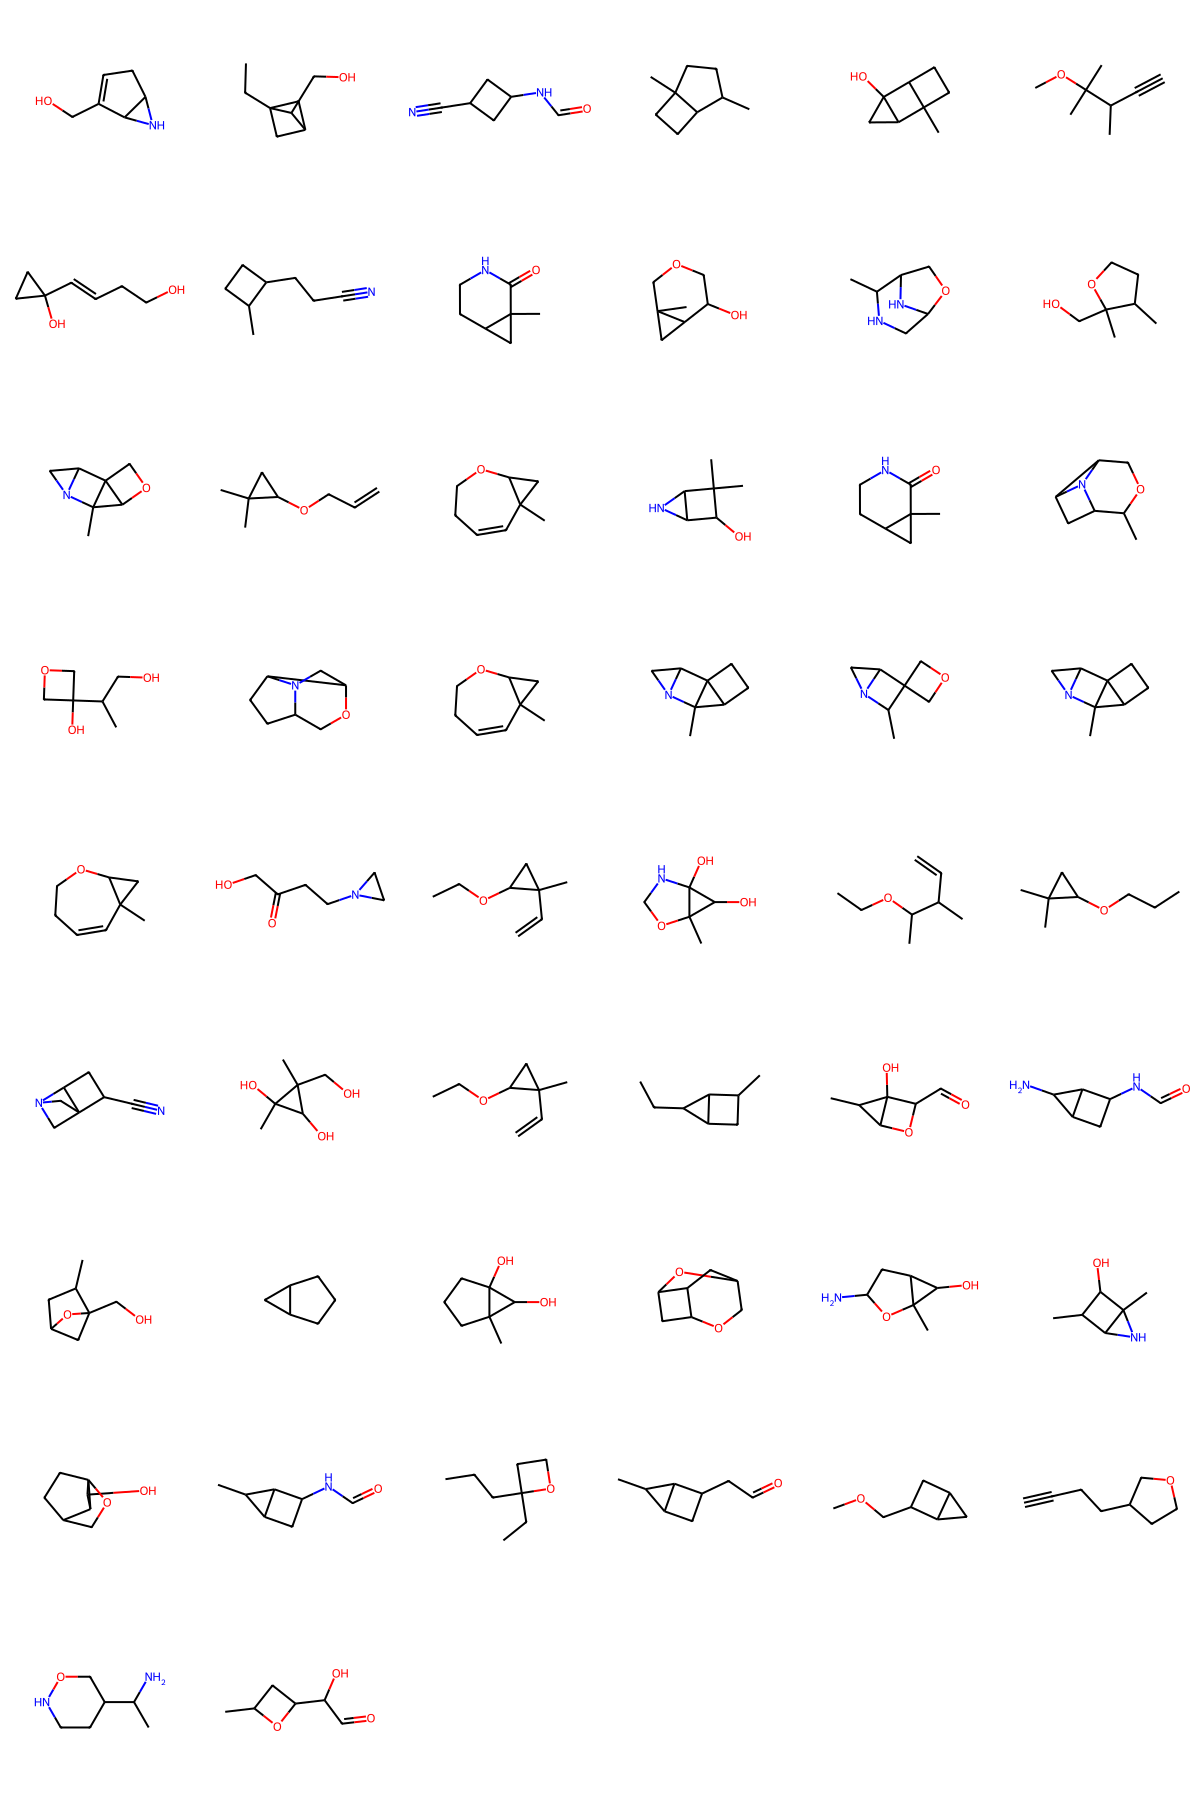

In [73]:
from IPython.utils import io
import pandas as pd
from rdkit.Chem import PandasTools as pt
with io.capture_output() as captured:
    mols = convert(n,e)
    mols = list(filter(lambda x: x is not None, mols))
    mols = strip(mols)
n_mols = pd.DataFrame(mols, columns=['ROMol'])
pt.FrameToGridImage(n_mols, molsPerRow=6)

In [74]:
from rdkit import Chem
from MolGAN.molecular_metrics import MolecularMetrics
import numpy as np

def evaluate_generated_molecules(mols, dataset, verbose=True):
    """
    Evaluates generated molecules using validity, uniqueness, and novelty.
    Args:
        mols: List of generated RDKit molecules
        dataset: The dataset object (must have .smiles attribute for novelty)
        verbose: If True, prints metrics
    Returns:
        dict with keys: validity, uniqueness, novelty
    """
    # Valid
    validity_mask = MolecularMetrics.valid_scores(mols)
    valid_mols = [m for m, v in zip(mols, validity_mask) if v]
    validity = np.mean(validity_mask)

    # Unique
    uniqueness = MolecularMetrics.unique_total_score(valid_mols)

    # Novelty
    novelty = MolecularMetrics.novel_total_score(valid_mols, dataset)

    if verbose:
        print(f"✅ Validity:   {validity*100:.2f}%")
        print(f"✅ Uniqueness: {uniqueness*100:.2f}%")
        print(f"✅ Novelty:    {novelty*100:.2f}%")

    return {
        'validity': validity,
        'uniqueness': uniqueness,
        'novelty': novelty
    }



In [75]:
# from MolGAN.evaluation import evaluate_generated_molecules


# 1. Generate molecules
n, e = g.generate(1000)
mols = [g.data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]
mols = list(filter(lambda m: m is not None, mols))

# 2. Evaluate (uses g.data.smiles as training set for novelty)
results = evaluate_generated_molecules(mols, g.data)

✅ Validity:   79.57%
✅ Uniqueness: 50.27%
✅ Novelty:    96.51%


✅ Loaded 133247 molecules with ≤9 atoms


,Molecule ID,Num Atoms,Num Bonds
0,0,1,0
1,1,1,0
2,2,1,0
3,3,2,1
4,4,2,1


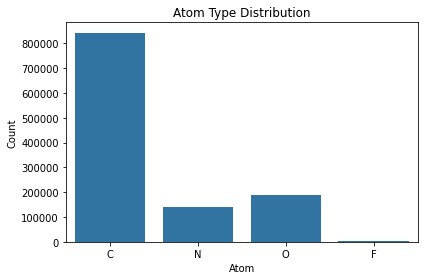

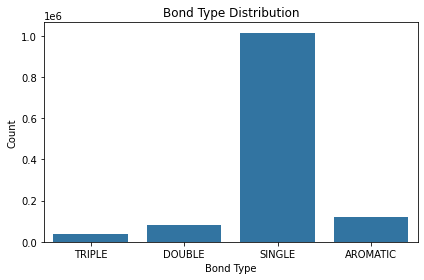

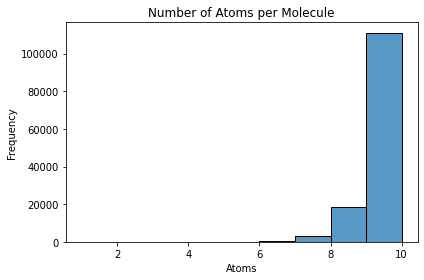

🔍 Showing 5 sample molecules:


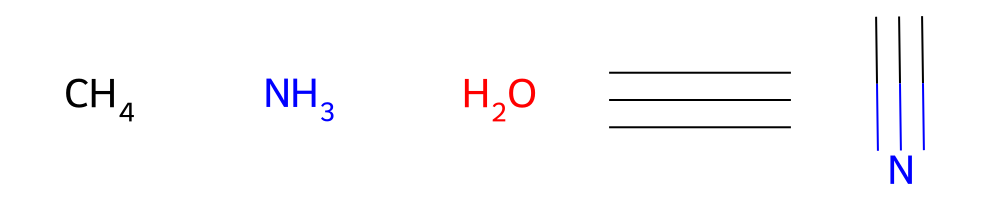

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import os

# Path to your dataset file
SDF_PATH = "MolGAN/data/gdb9/gdb9.sdf"  # update path if needed

# Load molecules using RDKit
supplier = Chem.SDMolSupplier(SDF_PATH)
molecules = [mol for mol in supplier if mol is not None and mol.GetNumAtoms() <= 9]

print(f"✅ Loaded {len(molecules)} molecules with ≤9 atoms")

# ---------- Basic Stats ----------
atom_counts = []
bond_counts = []
atom_type_counter = Counter()
bond_type_counter = Counter()

for mol in molecules:
    atom_counts.append(mol.GetNumAtoms())
    bond_counts.append(mol.GetNumBonds())

    for atom in mol.GetAtoms():
        atom_type_counter[atom.GetSymbol()] += 1

    for bond in mol.GetBonds():
        bond_type_counter[str(bond.GetBondType())] += 1

# ---------- Summary Table ----------
summary = pd.DataFrame({
    "Molecule ID": range(len(molecules)),
    "Num Atoms": atom_counts,
    "Num Bonds": bond_counts
})
display(summary.head())

# ---------- Atom Type Distribution ----------
plt.figure(figsize=(6, 4))
sns.barplot(x=list(atom_type_counter.keys()), y=list(atom_type_counter.values()))
plt.title("Atom Type Distribution")
plt.xlabel("Atom")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- Bond Type Distribution ----------
plt.figure(figsize=(6, 4))
sns.barplot(x=list(bond_type_counter.keys()), y=list(bond_type_counter.values()))
plt.title("Bond Type Distribution")
plt.xlabel("Bond Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- Atom Count Distribution ----------
plt.figure(figsize=(6, 4))
sns.histplot(atom_counts, bins=range(1, 11), kde=False)
plt.title("Number of Atoms per Molecule")
plt.xlabel("Atoms")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ---------- Sample Molecule Visualization ----------
print("🔍 Showing 5 sample molecules:")
Draw.MolsToImage(molecules[:5], molsPerRow=5)
